# Create DLPy Image Classification Model and Export to ONNX

This example uses SAS DLPy to create and train a CNN image classification model. The data used is the Fruits-360 dataset which contains many different classes of fruits. The model architecture is specified using DLPy's Sequential API. After training the model and scoring test images, it is deployed as an ONNX model. We then perform inference using two different (TensorFlow and Caffe2) back ends.

The open-source Fruits-360 training and test image datasets used in this example can be downloaded from the Horea Muresan GitHub repository <a href="https://github.com/Horea94/Fruit-Images-Dataset">Horea94/Fruit-Images-Dataset</a>.  

The example begins by [importing the required libraries](#importRequired) for the image classification task. Next, [start a CAS session](#connectCAS) and then [load the train and test model data](#loadImages). 

Use DLPy to [specify the sequential model architecture](#specifyModel), layer by layer.  Then [train the sequential CNN model](#fitModel) using the fruits training data.  

After training the image classification model, [score the test images](#scoreTest). After validating the model performance, [the trained model is deployed in ONNX format](#deployOnnx). 

Finally, the exported ONNX image classification model is prepared for inference with [TensorFlow](https://www.tensorflow.org/) and [Caffe2](https://caffe2.ai/) back ends.

<h3>Import Required Libraries <a name="importRequired"></a></h3>


Begin by importing `SWAT`. SWAT is a Python interface to SAS CAS. For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

Next, import DLPy and the `Sequential` class, as well as all layer types from DLPy `layers`, the `ImageTable` functions from `images`, and `GPU` from DLPy `model`.

In [1]:
import swat
from dlpy import Sequential
from dlpy.layers import *
from dlpy.images import ImageTable
from dlpy.model import Gpu
import warnings
warnings.filterwarnings('ignore') # Ignore all the warning messages in this tutorial

<h3>Start a CAS Session<a name="connectCAS"></a></h3>

After configuring your environment and loading required libraries and functions, connect to your CAS server. You will need to know your CAS server name and port number for this step.

In [2]:
s = swat.CAS(cas-server-name, cas-port-number)

<h3>Load Training and Test Images<a name="loadImages"></a></h3>


The `img_path` variable points to the server-accessible path to the model images. 

In [3]:
img_path='/disk/linux/dlpy/fruits'

tr_img = ImageTable.load_files(s, path=img_path+'/Training')
te_img = ImageTable.load_files(s, path=img_path+'/Test')

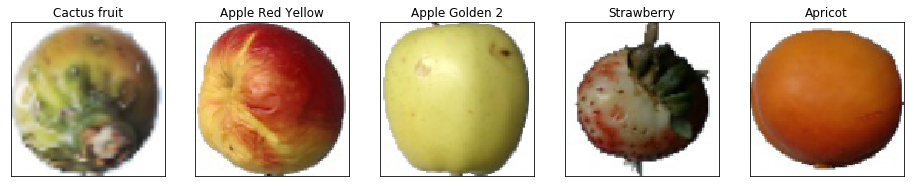

In [4]:
tr_img.show(randomize=True)

In [5]:
tr_img.image_summary

jpg                 41323
minWidth              100
maxWidth              100
minHeight             100
maxHeight             100
meanWidth             100
meanHeight            100
mean1stChannel    127.054
min1stChannel           0
max1stChannel         255
mean2ndChannel    149.024
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    179.441
min3rdChannel           0
max3rdChannel         255
dtype: object

<h3>Use DLPy to Build Sequential CNN Model <a name="specifyModel"></a></h3>

Now use SAS DLPy to define the sequential CNN model architecture, layer by layer, to build `model1`. 

The input layer of `model1` is configured for 100 x 100 color images, using mean BGR offset values determined in the training data. 

The output layer has 81 classes. 

In [6]:
model1 = Sequential(conn=s, model_table='Simple_CNN1')

model1.add(InputLayer(n_channels=3, width=100, height=100, scale=1, 
                      offsets=tr_img.channel_means))

model1.add(Conv2d(n_filters=64, width=5, height=5, stride=1, act='identity', 
                  include_bias=False))
model1.add(BN(act='relu'))
model1.add(Conv2d(n_filters=64, width=5, height=5, stride=1, act='identity', 
                  include_bias=False))
model1.add(BN(act='relu'))
model1.add(Pooling(width=2, height=2, stride=2, pool='max'))

model1.add(Conv2d(n_filters=128, width=5, height=5, stride=1, act='identity',
                  include_bias=False))
model1.add(BN(act='relu'))
model1.add(Conv2d(n_filters=128, width=5, height=5, stride=1, act='identity',
                  include_bias=False))
model1.add(BN(act='relu'))
model1.add(Pooling(width=2, height=2, stride=2, pool='max'))

model1.add(Dense(n=100))
model1.add(Dense(n=100))

model1.add(OutputLayer(n=81))

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [7]:
model1.print_summary()

,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,Input1,input,None,None,None,"(100, 100, 3)","(0, 0)"
1,Convo.1,convo,"(5, 5)",1,Identity,"(100, 100, 64)","(4800, 0)"
2,B.N.1,batchnorm,None,None,Relu,"(100, 100, 64)","(0, 128)"
3,Convo.2,convo,"(5, 5)",1,Identity,"(100, 100, 64)","(102400, 0)"
4,B.N.2,batchnorm,None,None,Relu,"(100, 100, 64)","(0, 128)"
5,Pool1,pool,"(2, 2)",2,Max,"(50, 50, 64)","(0, 0)"
6,Convo.3,convo,"(5, 5)",1,Identity,"(50, 50, 128)","(204800, 0)"
7,B.N.3,batchnorm,None,None,Relu,"(50, 50, 128)","(0, 256)"
8,Convo.4,convo,"(5, 5)",1,Identity,"(50, 50, 128)","(409600, 0)"
9,B.N.4,batchnorm,None,None,Relu,"(50, 50, 128)","(0, 256)"


<h3>Train the Sequential CNN Model<a name="fitModel"></a></h3>

After compiling and verifying the architecture of the image classification model, use `fit()` and the training data table `tr_img` to train the model. The training process should use mini batch size of 6, a maximum of 20 training epochs, and utilize one GPU (device GPU0) during processing. 

In [8]:
model1.fit(data=tr_img, 
           mini_batch_size=6, 
           max_epochs=20, 
           lr=1E-4, 
           valid_table=te_img,
           gpu=Gpu(devices=[0]),
           log_level=2)

NOTE: Either dataspecs or inputs need to be non-None, therefore inputs=_image_ is used
NOTE: Training from scratch.
NOTE: Only 1 out of 4 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 8740749.
NOTE:  The approximate memory cost is 2730.00 MB.
NOTE:  Initializing each layer cost       1.99 (s).
NOTE:  The total number of threads on each worker is 40.
NOTE:  The total mini-batch size per thread on each worker is 6.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 240.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:     81
NOTE:  Levels for the target variable:
NOTE:  Level      0: Apple Braeburn     
NOTE:  Level      1: Apple Golden 1     
NOTE:  Level      2: Apple Golden 2     
NOTE:  Level      3: Apple Golden 3     
NOTE:  Level      4: Apple Granny Smith 
NOTE:  Level      5: Apple Red 1        
NOTE:  Level      6: Apple Red 2        
NOTE:  Level   

,Descr,Value
0,Model Name,simple_cnn1
1,Model Type,Convolutional Neural Network
2,Number of Layers,14
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,4
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,2
8,Number of Batch Normalization Layers,4
9,Number of Weight Parameters,8739700


<h3>Score Test Images<a name="scoreTest"></a></h3>

Now use the trained `model1` and the `evaluate()` function to score images from the test image partition `te_img`.


In [9]:
model1.evaluate(te_img, gpu=Gpu(devices=[0]))

NOTE: Only 1 out of 4 available GPU devices are used.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read         13877
 1  Number of Observations Used         13877
 2  Misclassification Error (%)      9.937306
 3                   Loss Error      0.600275

[OutputCasTables]

          casLib              Name   Rows  Columns  \
 0  CASUSER(sas)  Valid_Res_qroW3p  13877       88   
 
                                             casTable  
 0  CASTable('Valid_Res_qroW3p', caslib='CASUSER(s...  

+ Elapsed: 5.46s, user: 16.2s, sys: 2.12s, mem: 2.8e+03mb

The results show that the trained model `model1` has a misclassification error of 9.9%. 

Use `plot_evaluate_res()` to generate a plot that shows the predicted probabilities for image classes.

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sas).


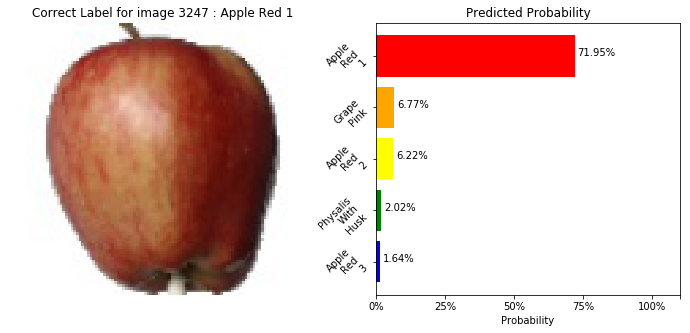

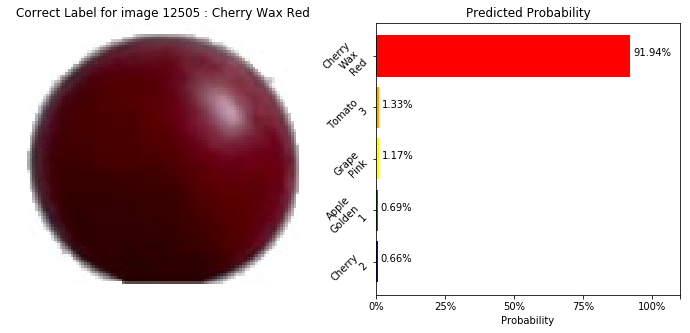

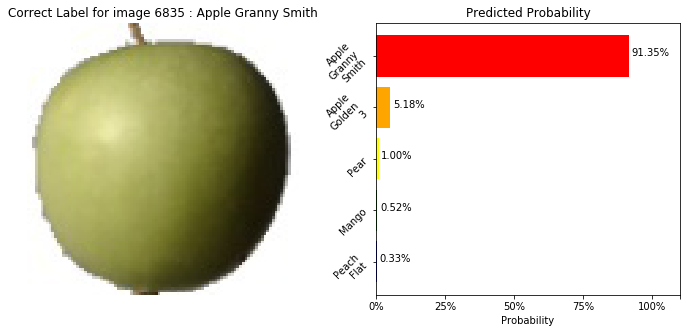

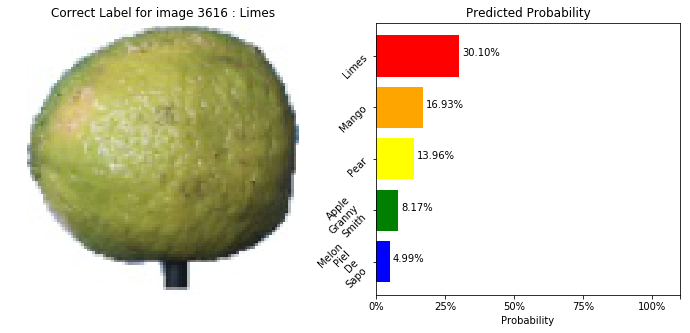

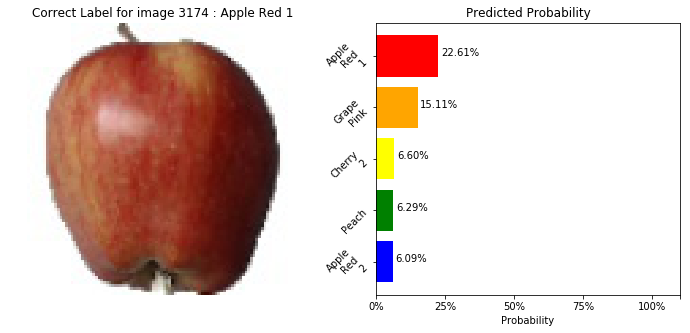

In [10]:
model1.plot_evaluate_res(randomize=True)

<h3>Deploy Trained Image Classification Model in ONNX Format<a name="deployOnnx"></a></h3>


Now deploy the trained SAS DLPy image classification model using the <a href="https://onnx.ai/">ONNX format</a> for interchangeable AI models. You can deploy the ONNX model by supplying the trained weights in two ways: fetching directly from the CAS server, or through a local, client-side CSV file.

The following code deploys `model1` to the folder at `/disk/linux/dlpy` in ONNX format, while fetching the model weights from the server.  If this is a large model with many parameters, this may take a longer time.

In [11]:
model1.deploy(path='/disk/linux/dlpy', output_format='onnx')

NOTE: Model weights will be fetched from server
NOTE: ONNX model file saved successfully.


Alternatively, to specify the weights stored in a local file, first use `save_weights_csv()` to save the trained model weights to a CSV file. The function names the output file by appending `_weights.csv` to the model name specified at creation, `Simple_CNN1`.

In [12]:
model1.save_weights_csv(path='/disk/linux/dlpy')

NOTE: Model weights csv saved successfully.


Now you can use the `model_weights` parameter with the DLPy `deploy()` function to point to the CSV weights file, when deploying the model to ONNX.

In [13]:
model1.deploy(path='/disk/linux/dlpy', output_format='onnx', model_weights='/disk/linux/dlpy/Simple_CNN1_weights.csv')

NOTE: Model weights will be loaded from csv.
NOTE: ONNX model file saved successfully.


<h3>Prepare Exported ONNX Model for TensorFlow<a name="onnxTensorFlow"></a></h3>

ONNX is an open ecosystem for interchangeable AI models. In other words, deep learning models saved in ONNX format can be able run by a variety of tools.  For more information, check out [this page from ONNX's GitHub](https://github.com/onnx/tutorials).  Here, we will be using a TensorFlow backend for ONNX. The example code that follows uses the image classification model `model1` created in DLPy and exported as an ONNX model.  

Begin by importing required Python libraries for this example:

In [14]:
import onnx
import cv2
from PIL import Image
import numpy as np
import onnx_tf.backend

Now use the `onnx.load()` function and specify the path to the ONNX model. 

In [15]:
model = onnx.load('/disk/linux/dlpy/Simple_CNN1.onnx')

Now use `onnx_tf.backend.prepare()` to obtain a TensorflowRep class object representing the ONNX model.


In [16]:
tf_rep = onnx_tf.backend.prepare(model)

In [17]:
tf_rep.inputs # Input nodes to the model

['Input1']

In [18]:
tf_rep.outputs # Output nodes from the model

['Output1']

In [19]:
tf_rep.tensor_dict # All nodes in the model

{'Convo.1_w': <tf.Tensor 'Const:0' shape=(64, 3, 5, 5) dtype=float32>,
 'B.N.1_scale': <tf.Tensor 'Const_1:0' shape=(64,) dtype=float32>,
 'B.N.1_bias': <tf.Tensor 'Const_2:0' shape=(64,) dtype=float32>,
 'B.N.1_mean': <tf.Tensor 'Const_3:0' shape=(64,) dtype=float32>,
 'B.N.1_variance': <tf.Tensor 'Const_4:0' shape=(64,) dtype=float32>,
 'Convo.2_w': <tf.Tensor 'Const_5:0' shape=(64, 64, 5, 5) dtype=float32>,
 'B.N.2_scale': <tf.Tensor 'Const_6:0' shape=(64,) dtype=float32>,
 'B.N.2_bias': <tf.Tensor 'Const_7:0' shape=(64,) dtype=float32>,
 'B.N.2_mean': <tf.Tensor 'Const_8:0' shape=(64,) dtype=float32>,
 'B.N.2_variance': <tf.Tensor 'Const_9:0' shape=(64,) dtype=float32>,
 'Convo.3_w': <tf.Tensor 'Const_10:0' shape=(128, 64, 5, 5) dtype=float32>,
 'B.N.3_scale': <tf.Tensor 'Const_11:0' shape=(128,) dtype=float32>,
 'B.N.3_bias': <tf.Tensor 'Const_12:0' shape=(128,) dtype=float32>,
 'B.N.3_mean': <tf.Tensor 'Const_13:0' shape=(128,) dtype=float32>,
 'B.N.3_variance': <tf.Tensor 'Const

<h3>Load and Preprocess Test Image<a name="loadTF_Images"></a></h3>

Now load the test image and subtract BGR channel means.

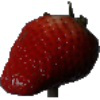

In [20]:
# Here, we display the image, which is a Strawberry
img = Image.open('r_321_100.jpg')
display(img)

In [21]:
# load image, set channels first, and subtract channel means
img = cv2.imread('r_321_100.jpg')
img = np.transpose(img, (2,0,1))
img = np.reshape(img, (1, 3, 100, 100)).astype(np.float32)
img -= np.array(tr_img.channel_means).reshape(1, 3, 1, 1)

<h3>Run the Exported ONNX Model Using TensorFlow backend<a name="runOnnxRun"></a></h3>

In [22]:
res = tf_rep.run(img)

Define a function to print out the label names.

In [23]:
# The labels file is located in the src/image_classification/utils path of the dataset
labels_path = os.path.join(img_path, '/disk/linux/dlpy/fruits/src/image_classification/utils/labels')
with open(labels_path) as f:
    labels = f.readlines()
labels = [x.strip() for x in labels]
CLASS_INDEX = dict(zip(range(81), labels))

In [24]:
def decode_predictions(pred):
    results = []
    for p in pred:
        top_indices = p.argsort()[-5:][::-1]
        result = [(CLASS_INDEX[i], p[i]) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results

In [25]:
decode_predictions(res[0])

[[('Strawberry', 0.47226807),
  ('Tamarillo', 0.1504392),
  ('Carambula', 0.054151684),
  ('Peach', 0.048632793),
  ('Papaya', 0.04647698)]]

<h3>Run Exported ONNX Model Using Caffe2 Backend<a name="onnxCaffe2"></a></h3>


In [26]:
import caffe2.python.onnx.backend

In [27]:
caffe2_rep = caffe2.python.onnx.backend.prepare(model)

In [28]:
output = caffe2_rep.run(img)

In [29]:
decode_predictions(output[0])

[[('Strawberry', 0.4722676),
  ('Tamarillo', 0.15043928),
  ('Carambula', 0.054151867),
  ('Peach', 0.04863298),
  ('Papaya', 0.046477087)]]

In [30]:
s.endsession()

+ Elapsed: 0.000232s, mem: 0.195mb